# Conversion in a stirred-tank reactor

Now that we've learned the reaction kinetics in a batch experiments. Let's couple the NODE to a process model to simulate the bio-chemical conversion in a continuously stirred-tank reactor (CSTR). This is a *hybrid* model since it combines a mechanistic process model with a data-driven model.

<img src="./figs/CSTR.svg" width=300>

The reaction in a CSTR can described by the following equation,

$$ \cfrac{\mathrm{d}C_i}{\mathrm{d}t} = \cfrac{Q}{V}\, \left(C_{in}-C_i \right) + R $$

with,

$C_i$ the concentration of component $i$, 

$Q$ the volumetric flow rate, 

$V$ the reactor volume, 

$C_{in}$ influent concentration and 

$R$ the reaction rate, which is a function of the concentration in the reactor as is shown in the previous notebook.

In [1]:
include("./src/helper-functions.jl");

In [2]:
using OrdinaryDiffEq
using Plots
using DiffEqFlux, Flux

## Loading the trained parameters

The first step is to load the parameters of the trained neural differential equation.

In [3]:
text = open(f->read(f, String), "model/trainedModel.csv") |> s -> split(s, "\n")[1:end-1] 
p = parse.(Float32,text)

257-element Array{Float32,1}:
 -0.60065514 
  1.042311   
 -0.22698568 
 -0.4247081  
 -1.0374964  
  0.3908787  
 -0.14085488 
  0.4752876  
 -1.05771    
 -0.5003168  
 -0.21593942 
 -0.32766807 
  0.3697218  
  ⋮          
 -0.35878715 
 -1.0722468  
  0.78707886 
 -1.126508   
  0.31857586 
  0.116079174
  0.06531635 
  0.13816889 
 -0.28076467 
  0.02488915 
 -1.5570972  
 -0.44492856 

Secondly, we define the same neural network structure as before

In [4]:
ann = Chain(Dense(3, 20, σ), Dense(20, 8, σ), Dense(8,1), x->x.*[1.0; 1.0; -1.0])
~, re = Flux.destructure(ann);

Now we put the trained parameterset $p$ in the neural network.

In [5]:
trainedModel(u,p,t) = re(p)(u);

In [6]:
prob = ODEProblem(trainedModel, C₀, (0, 240))

function predict_neuralODE(C₀)
    Array(solve(prob,Tsit5(),u0=C₀,p=p,saveat=data[2]))
end

UndefVarError: UndefVarError: C₀ not defined

Quickly check if everything is working find and we obtain the same simulation results.

In [7]:
C₀ = Float32[60.0; 60.0; 15.0]
data = generate_true_solution(C₀, 240.0);
pred = predict_neuralODE(C₀)
pl = prediction_vs_data(data, pred)

UndefVarError: UndefVarError: predict_neuralODE not defined

Defining the reactor model for both the true model as the neural ODE model. $nu$() is defined in the helper functions loaded at the start of the notebook.

In [8]:
function reactor!(du, u, p, t)
  G, L, Es = u
  Gᵢ, Lᵢ, Esᵢ = C₀
  p₂ = (9.03f-2, 5.0f-2, 1.9f1)

  dG  = du[1] = 1/V*(Qᵢ*Gᵢ-Qᵢ*G) - ν(G, L, Es, p₂)
  dL  = du[2] = 1/V*(Qᵢ*Lᵢ-Qᵢ*L) - ν(G, L, Es, p₂)
  dEs = du[3] = 1/V*(Qᵢ*Esᵢ-Qᵢ*Es) + ν(G, L, Es, p₂)
end

function reactorNN!(du, u, p, t)
  G, L, Es = u
  Gᵢ, Lᵢ, Esᵢ = C₀
    
  dG  = du[1] = 1/V*(Qᵢ*Gᵢ-Qᵢ*G) - trainedModel(u, p, t)[3]
  dL  = du[2] = 1/V*(Qᵢ*Lᵢ-Qᵢ*L) - trainedModel(u, p, t)[3]
  dEs = du[3] = 1/V*(Qᵢ*Esᵢ-Qᵢ*Es) + trainedModel(u, p, t)[3]
end;

Defining the reactor dimensions, flow rate and inlet concentrations

In [9]:
V = 10.0
Qᵢ = 0.05
C₀ = [60.0; 60.0; 0.0];
tₑ = 480

480

Defining an ODE for the true model and the neural ODE model

In [10]:
probReactorNN = ODEProblem(reactorNN!, C₀, (0.0, tₑ), p)
solNN = solve(probReactorNN, Tsit5())

probReactor = ODEProblem(reactor!, C₀, (0.0, tₑ), p)
sol = solve(probReactor, Tsit5());

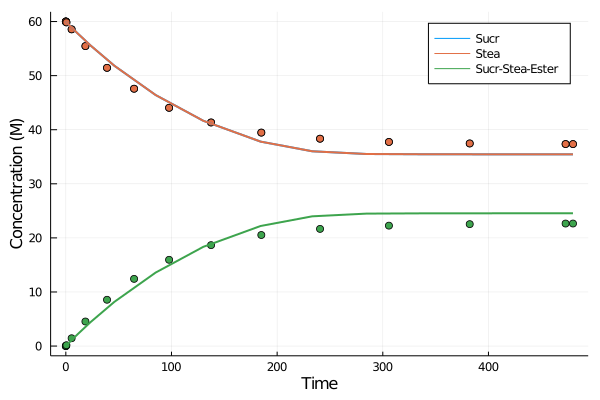

In [16]:
pl = plot()

G = [C[1] for C in sol.u]
L = [C[2] for C in sol.u]
Es = [C[3] for C in sol.u]

scatter!(pl, sol.t, G, label="")
scatter!(pl, sol.t, L, label="")
scatter!(pl, sol.t, Es, label="")

GNN = [C[1] for C in solNN.u]
LNN = [C[2] for C in solNN.u]
EsNN = [C[3] for C in solNN.u]

lcs = pl.series_list
plot!(pl, solNN.t, GNN, lc=lcs[1][:linecolor], label="Sucr", lw = 2)
plot!(pl, solNN.t, LNN, lc=lcs[2][:linecolor], label="Stea", lw = 2)
plot!(pl, solNN.t, EsNN, lc=lcs[3][:linecolor], label= "Sucr-Stea-Ester", lw = 2,
    xlabel="Time", ylabel="Concentration (M)")

With only 9 experiments we have trained a model that works well at estimating the reaction rate at different concentrations levels during the start up of a CSTR reactor. Some concluding remarks:

* This CSTR model will only work within the boundaries of trained concentrations, do not expect miracles.
* Certain combination of concentrations might lead to weird reactions rates more experiment should be added to avoid this or the structure of the neural network can be changed to included prior-knowledge on the reaction kinetics

## Read more

More examples on neural differential equations can be found in the *DiffEqFlux.jl* [documentation](https://diffeqflux.sciml.ai/stable/). More information on machine learning in julia can be found in the *flux.jl* [documentation](https://fluxml.ai/).

If you find any *bugs*, *typos* or remarks on the structure and/or content of this workshop please [raise an issue](https://github.com/Beramos/Workshop-NeuralODE-2020/issues).

-----
Contact: [Bram.De.Jaegher@gmail.com](mailto:bram.de.jaegher@gmail.com)

![footer](./figs/footerLogo.svg)
